# Plagiarism Detection, Feature Engineering

For this project I am  building a plagiarism detector that examines an answer text file and performs binary classification; predicting either plagiarized or not, depending on how similar that text file is to the source file.

We will cover the cleaning, processing, and feature engineering of the data in this notebook. We will also select down a few features for modeling at the very end of this notebook. We will break this notebook down into several general steps outlined below:

* Clean and pre-process the data.
* Define features for similarity between an input answer text and a source text.
* Select "good" features, by analyzing the correlations between different features.
* Create train/test `.csv` files that hold the relevant features and class labels for train/test data points.

---

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

This plagiarism dataset is made of multiple text files; each of these files has characteristics that are is summarized in a `.csv` file named `file_information.csv`, which we can read in using `pandas`.

In [8]:
csv_file = 'data/file_information.csv'
plagiarism_df = pd.read_csv(csv_file)

plagiarism_df.tail(10)

,File,Task,Category
90,g4pE_taska.txt,a,heavy
91,g4pE_taskb.txt,b,light
92,g4pE_taskc.txt,c,cut
93,g4pE_taskd.txt,d,non
94,g4pE_taske.txt,e,non
95,orig_taska.txt,a,orig
96,orig_taskb.txt,b,orig
97,orig_taskc.txt,c,orig
98,orig_taskd.txt,d,orig
99,orig_taske.txt,e,orig


---
## Pre-Process the Data


First we are going to encode the tasks, categories, and classes for each observation. 

In [3]:
def col_encoder(row, col_flag):
    '''
        Conditional network to encode classes, tasks, categories
        
        Returns: label of the class and category
    '''
    if col_flag == 'class':
        if row == 'non':
            label = 0
        if row == 'orig':
            label = -1
        if row in ['heavy','light','cut']:
            label = 1
        return label
    if col_flag == 'category':
        if row == 'non':
            label = 0 
        if row == 'heavy':
            label = 1
        if row == 'light':
            label = 2
        if row == 'cut':
            label = 3
        if row == 'orig':
            label = -1
        return label

In [4]:
# Read in a csv file and return a transformed dataframe
def numerical_dataframe(csv_file='data/file_information.csv'):
    '''
    Reads a csv file that has `File`, `Category` and `Task` columns.
    Applies the col_encoder function to the dataframe produced from csv file
       param csv_file: The directory for the file_information.csv file
       return: A dataframe with numerical categories and a new `Class` label column
    '''
    
    df = pd.read_csv(csv_file)
    df['Class'] = df.Category.apply(lambda r: col_encoder(r, 'class'))
    df['Category'] = df.Category.apply(lambda r: col_encoder(r, 'category'))

    return df


In [5]:
# informal testing, print out the results of a called function
transformed_df = numerical_dataframe(csv_file ='data/file_information.csv')

transformed_df.head(10)

,File,Task,Category,Class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0
5,g0pB_taska.txt,a,0,0
6,g0pB_taskb.txt,b,0,0
7,g0pB_taskc.txt,c,3,1
8,g0pB_taskd.txt,d,2,1
9,g0pB_taske.txt,e,1,1


## Text Processing & Splitting Data

We will use two similarity metrics for this project, and to create those metrics we need the text. We have built out some text preprocessing functions to clean up the data for this notebook. See the file `helpers.py` for code and documentation for text preprocessing.

In [6]:
import helpers 

# create a text column 
text_df = helpers.create_text_column(transformed_df)
text_df.head()

,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [7]:
# print out a sample text
row_idx = 0 

sample_text = text_df.iloc[0]['Text']

print('Sample processed text:\n\n', sample_text)

Sample processed text:

 inheritance is a basic concept of object oriented programming where the basic idea is to create new classes that add extra detail to existing classes this is done by allowing the new classes to reuse the methods and variables of the existing classes and new methods and classes are added to specialise the new class inheritance models the is kind of relationship between entities or objects  for example postgraduates and undergraduates are both kinds of student this kind of relationship can be visualised as a tree structure where student would be the more general root node and both postgraduate and undergraduate would be more specialised extensions of the student node or the child nodes  in this relationship student would be known as the superclass or parent class whereas  postgraduate would be known as the subclass or child class because the postgraduate class extends the student class  inheritance can occur on several layers where if visualised would display a l

## Split data into training and test sets

The next cell will add a `Datatype` column to a given DataFrame to indicate if the record is: 
* `train` - Training data, for model training.
* `test` - Testing data, for model evaluation.
* `orig` - The task's original answer from wikipedia.

### Stratified sampling

Again, we are using some helper functions from `helpers.py`. This implements [stratified random sampling](https://en.wikipedia.org/wiki/Stratified_sampling) to randomly split data by task & plagiarism amount. Stratified sampling ensures that we get well balanced training and test data. Approximately 25% of the data is held out for testing and 75% for training.

The function **train_test_dataframe** takes in a DataFrame that it assumes has `Task` and `Category` columns, and, returns a modified dataframe that indicates which `Datatype` (train, test, or orig). 

In [8]:
random_seed = 945

# create new df with Datatype (train, test, orig) column
complete_df = helpers.train_test_dataframe(text_df, random_seed=random_seed)

# check results
complete_df.head(10)

,File,Task,Category,Class,Text,Datatype
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...,train
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...,train
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...,train
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...,train
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...,train
5,g0pB_taska.txt,a,0,0,inheritance is a basic concept in object orien...,train
6,g0pB_taskb.txt,b,0,0,pagerank pr refers to both the concept and the...,train
7,g0pB_taskc.txt,c,3,1,vector space model is an algebraic model for r...,train
8,g0pB_taskd.txt,d,2,1,bayes theorem relates the conditional and marg...,train
9,g0pB_taske.txt,e,1,1,dynamic programming is a method for solving ma...,train



# Similarity Features 

We will use [this paper on plagiarism detection](https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c412841_developing-a-corpus-of-plagiarised-short-answers/developing-a-corpus-of-plagiarised-short-answers.pdf) to calculate some similarity features for this data. 

> Features like **containment** and **longest common subsequence**. 


## Feature Engineering

### Containment

First we will create **containment features**. Containment works on [n-grams](https://en.wikipedia.org/wiki/N-gram). 

> Containment is the mathematical intersection of the n-gram word count of the Wikipedia Source Text (S) with the n-gram word count of the input Answer Text (A) *divided* by the n-gram word count of the Input Answer Text.

$$ \frac{\sum{count(\text{ngram}_{A}) \cap count(\text{ngram}_{S})}}{\sum{count(\text{ngram}_{A})}} $$

If the two texts have no n-grams in common, the containment will be 0, but if _all_ their n-grams intersect then the containment will be 1.


### Containment calculation

We will use a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to produce the n-grams.    

In [9]:
def make_count_vector(corpus, ngrams):
    '''
    Makes a count vectorizer matrix based on the number of ngrams. 
    
    param corpus: an array of strings that are input text to CountVectorized.
    param ngrams: the max number of ngrams to be calculated. 
    
    return: CountVectorizer object
    '''
    try: 
        CountVectorizer()
    except IOError:
        print('Import CountVectorizer from sklean.feature_extraction.text')
    count_vec = CountVectorizer(analyzer='word', ngram_range=(ngrams,ngrams))
    return count_vec.fit_transform(corpus)

In [10]:
def calculate_containment(df, n, answer_filename):
    '''
    Calculates the containment between an input text and its associated source text.
    This function creates a count of ngrams (of a size, n) for each text file.
    Then calculates the containment.
       param df: A dataframe 
       param n: An integer that defines the ngram size
       param answer_filename: A filename for am input answer text
       
       return: A single containment value that represents the similarity
           between an input text and its source text.
    '''
    task_letter_idx = -5
    task = answer_filename[task_letter_idx]

    source = df[(df['Task'] == task) & (df['Datatype']=='orig')]['Text']
    source_idx = source.index[0]
    
    answer = df[df['File'] == answer_filename]['Text']
    answer_idx = answer.index[0]
    
    count_vec = make_count_vector([answer[answer_idx], source[source_idx]], n)
    # intersection can be thought of as the minimum between the source and answer array
    intersect_sum = np.minimum(count_vec[0].toarray(), count_vec[1].toarray()).sum()
      
    answer_sum = count_vec[0].toarray().sum()
    containment = intersect_sum/answer_sum
    
    return containment


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
# Let's make sure this works like we want
n = 3

# The first few files
test_indices = range(5)

# Calculate containment
category_vals = []
containment_vals = []
for i in test_indices:
    category_vals.append(complete_df.loc[i, 'Category'])
    filename = complete_df.loc[i, 'File']
    # Run containment calculation
    c = calculate_containment(complete_df, n, filename)
    containment_vals.append(c)

print('Original category values: \n', category_vals, '/n')
print(str(n)+'-gram containment values: \n', containment_vals)

Original category values: 
 [0, 3, 2, 1, 0] /n
3-gram containment values: 
 [0.009345794392523364, 0.9641025641025641, 0.6136363636363636, 0.15675675675675677, 0.031746031746031744]


---
## Longest Common Subsequence

Containment a good way to find overlap in word usage between two documents; it may help identify cases of cut-and-paste as well as paraphrased levels of plagiarism. Since plagiarism is a fairly complex task with varying levels, it's often useful to include other measures of similarity. The paper also discusses a feature called **longest common subsequence**.

> The longest common subsequence is the longest string of words (or letters) that are *the same* between the Wikipedia Source Text (S) and the Student Answer Text (A). This value is also normalized by dividing by the total number of words (or letters) in the  Student Answer Text. 


### LCS Calculation

I found this video helpful in determining how to calculate LCS 

[LCS video](https://www.youtube.com/watch?v=NnD96abizww)

As an example of how to calculate the LCS consider the following simple example:

* A = "ABCD"
* S = "BD"

Here the longest subsequence of _letters_ here is 2 (B and D are in sequence in both strings). And we can calculate LCS by looking at relationships between each letter in the two strings, A and S.

As a matrix this looks like the following:

<img src='matrix_1.png' width=40% />

This starts out as a matrix that has as many columns and rows as letters in the strings S and O **+1** additional row and column, filled with zeros on the top and left sides. Such that, instead of a 2x4 matrix it is a 3x5.

Now, we can fill this matrix up by breaking it into smaller LCS problems. For example, let's first look at the shortest substrings: the starting letter of A and S. We'll first ask, what is the Longest Common Subsequence between these two letters "A" and "B"? 

**Here, the answer is zero.**

<img src='matrix_2.png' width=30% />

Then, what is the LCS between "AB" and "B"?

**We have a match, and can assign it a value of 1**.

<img src='matrix_3_match.png' width=25% />

If we continue, we get to a final matrix that looks as follows, with a **2** in the bottom right corner.

<img src='matrix_6_complete.png' width=25% />

The final LCS will be that value **2** *normalized* by the number of n-grams in A. So, our normalized value is **0.5**.

### The matrix rules

One thing to notice here is that, you can efficiently fill up this matrix one cell at a time. Each grid cell only depends on the values in the grid cells that are directly on top and to the left of it, or on the diagonal/top-left. The rules are as follows:

* Start with a matrix that has one extra row and column of zeros.
* As you traverse your string:
    * If there is a match, fill that grid cell with the value to the top-left of that cell *plus* one. So, in our case, when we found a matching B-B, we added +1 to the value in the top-left of the matching cell, 0.
    * If there is not a match, take the *maximum* value from either directly to the left or the top cell, and carry that value over to the non-match cell.

<img src='matrix_rules.png' width=50% />

After completely filling the matrix, **the bottom-right cell will hold the non-normalized LCS value**.

In [13]:
import numpy as np
import helpers

In [14]:
A = "i think pagerank is a link analysis algorithm used by google that uses a system of weights attached to each element of a hyperlinked set of documents"
S = "pagerank is a link analysis algorithm used by the google internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents"


In [15]:
# Compute the normalized LCS given an answer text and a source text
def lcs_norm_word(answer_text, source_text):
    '''
    Computes the longest common subsequence of words in two texts; returns a normalized value.
       param answer_text: The pre-processed text for an answer text
       param source_text: The pre-processed text for an answer's associated source text
       return: A normalized LCS value'''
    
    ans = answer_text.split()
    src = source_text.split()
    mat = np.zeros((len(ans)+1, len(src)+1))
    
    for i in range(len(ans)):
        for j in range(len(src)):
            if ans[i] == src[j]:
                mat[i+1,j+1] = mat[i,j]+1
            else: 
                mat[i+1,j+1] = max(mat[i,j+1], mat[i+1,j])
                
    lcs_score = mat[-1,-1] / len(ans)
    return lcs_score


Finally, take a look at a few resultant values for `lcs_norm_word`. Just like before, you should see that higher values correspond to higher levels of plagiarism.

In [16]:
test_indices = range(5) # look at first few files

category_vals = []
lcs_norm_vals = []
# iterate through first few docs and calculate LCS
for i in test_indices:
    category_vals.append(complete_df.loc[i, 'Category'])
    # get texts to compare
    answer_text = complete_df.loc[i, 'Text'] 
    task = complete_df.loc[i, 'Task']
    # we know that source texts have Class = -1
    orig_rows = complete_df[(complete_df['Class'] == -1)]
    orig_row = orig_rows[(orig_rows['Task'] == task)]
    source_text = orig_row['Text'].values[0]
    
    # calculate lcs
    lcs_val = lcs_norm_word(answer_text, source_text)
    lcs_norm_vals.append(lcs_val)

# print out result, does it make sense?
print('Original category values: \n', category_vals)
print()
print('Normalized LCS values: \n', lcs_norm_vals)

Original category values: 
 [0, 3, 2, 1, 0]

Normalized LCS values: 
 [0.1917808219178082, 0.8207547169811321, 0.8464912280701754, 0.3160621761658031, 0.24257425742574257]


---
# Create All Features

Let's bring all this together to finalize our feature engineered dataset. 

### Creating Multiple Containment Features

> This function returns a list of containment features, calculated for a given `n` and for *all* files in a df (assumed to the the `complete_df`).

For our original files, the containment value is set to a special value, -1.

In [17]:
# Function returns a list of containment features, calculated for a given n 
def create_containment_features(df, n, column_name=None):
    
    containment_values = []
    
    if(column_name==None):
        column_name = 'c_'+str(n) # c_1, c_2, .. c_n
    
    for i in df.index:
        file = df.loc[i, 'File']
        # Computes features using calculate_containment function
        if df.loc[i,'Category'] > -1:
            c = calculate_containment(df, n, file)
            containment_values.append(c)
        # Sets value to -1 for original tasks 
        else:
            containment_values.append(-1)
    
    print(str(n)+'-gram containment features created!')
    return containment_values


### Creating LCS features

In [18]:
def create_lcs_features(df, column_name='lcs_word'):
    
    lcs_values = []
    
    for i in df.index:
        if df.loc[i,'Category'] > -1:
            answer_text = df.loc[i, 'Text'] 
            task = df.loc[i, 'Task']
            orig_rows = df[(df['Class'] == -1)]
            orig_row = orig_rows[(orig_rows['Task'] == task)]
            source_text = orig_row['Text'].values[0]

            # Calculate lcs
            lcs = lcs_norm_word(answer_text, source_text)
            lcs_values.append(lcs)
        else:
            lcs_values.append(-1)

    print('LCS features created!')
    return lcs_values
    

In [19]:
# Define an ngram range
ngram_range = range(1,15)
features_list = []

all_features = np.zeros((len(ngram_range)+1, len(complete_df)))

# Calculate features for containment for ngrams in range
i=0
for n in ngram_range:
    column_name = 'c_'+str(n)
    features_list.append(column_name)
    # create containment features
    all_features[i]=np.squeeze(create_containment_features(complete_df, n))
    i+=1

# Calculate features for LCS_Norm Words 
features_list.append('lcs_word')
all_features[i]= np.squeeze(create_lcs_features(complete_df))

# create a features dataframe
features_df = pd.DataFrame(np.transpose(all_features), columns=features_list)

# Print all features/columns
print()
print('Features: ', features_list)
print()

1-gram containment features created!
2-gram containment features created!
3-gram containment features created!
4-gram containment features created!
5-gram containment features created!
6-gram containment features created!
7-gram containment features created!
8-gram containment features created!
9-gram containment features created!
10-gram containment features created!
11-gram containment features created!
12-gram containment features created!
13-gram containment features created!
14-gram containment features created!
LCS features created!

Features:  ['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'lcs_word']



## Correlated Features

Our features measure similarity between two texts. However, if features are too highly correlated that will cause most models to overfit on those features. As such, we need to prune features with high correlation values. This is a bit of a dark art, as there do not seem to be any hard rules for what to keep. We will try several iterations of modeling and present the best iteration of features. 

In [20]:
corr_matrix = features_df.corr().abs().round(2)
display(corr_matrix)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,lcs_word
c_1,1.00,0.94,0.90,0.89,0.88,0.87,0.87,0.87,0.86,0.86,0.86,0.86,0.86,0.86,0.97
c_2,0.94,1.00,0.99,0.98,0.97,0.96,0.95,0.94,0.94,0.93,0.92,0.92,0.91,0.91,0.98
c_3,0.90,0.99,1.00,1.00,0.99,0.98,0.98,0.97,0.96,0.95,0.95,0.94,0.94,0.93,0.97
c_4,0.89,0.98,1.00,1.00,1.00,0.99,0.99,0.98,0.98,0.97,0.97,0.96,0.96,0.95,0.95
c_5,0.88,0.97,0.99,1.00,1.00,1.00,1.00,0.99,0.99,0.98,0.98,0.97,0.97,0.97,0.95
c_6,0.87,0.96,0.98,0.99,1.00,1.00,1.00,1.00,0.99,0.99,0.99,0.98,0.98,0.98,0.94
c_7,0.87,0.95,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.99,0.98,0.93
c_8,0.87,0.94,0.97,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.99,0.92
c_9,0.86,0.94,0.96,0.98,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.91
c_10,0.86,0.93,0.95,0.97,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.91


In [21]:
import seaborn as sns

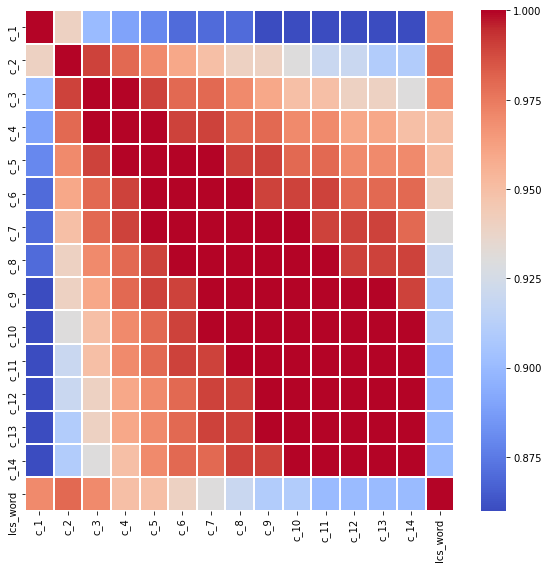

In [22]:
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, cmap='coolwarm',linewidths=1)
plt.tight_layout()

Keep c1, c2, c3, c4, and lcs_wrd

In [23]:
def train_test_data(complete_df, features_df, selected_features):
    '''
    Gets selected training and test features from given dataframes, and 
    returns tuples for training and test features and their corresponding class labels.
       
       param complete_df: A dataframe with our processed text data, datatypes, and labels
       param features_df: A dataframe of similarity features
       param selected_features: An array of selected features in `features_df`
       return: training and test features and labels: (train_x, train_y), (test_x, test_y)'''
    
    df = pd.concat([complete_df, features_df], axis=1)
    # get the training features
    train_x = df[df['Datatype']=='train'].drop('Class', axis=1)
    train_x = train_x[selected_features].values
    # And training class labels (0 or 1)
    train_y = df[df['Datatype']=='train']['Class'].values
    
    # get the test features and labels
    test_x = df[df['Datatype']=='test'].drop('Class', axis=1)
    test_x = test_x[selected_features].values
    test_y = df[df['Datatype']=='test']['Class'].values
    
    return (train_x, train_y), (test_x, test_y)
    

In [24]:
# Selecting our best features
selected_features = ['c_1', 'c_2','c_3','c_4', 'lcs_word']

(train_x, train_y), (test_x, test_y) = train_test_data(complete_df, features_df, selected_features)

# These should add up to 95 (100 - 5 original files)
print('Training size: ', len(train_x))
print('Test size: ', len(test_x))
print()
print('Training df sample: \n', train_x[:10])

Training size:  70
Test size:  25

Training df sample: 
 [[0.39814815 0.07906977 0.00934579 0.         0.19178082]
 [1.         0.98469388 0.96410256 0.94329897 0.82075472]
 [0.86936937 0.71945701 0.61363636 0.51598174 0.84649123]
 [0.59358289 0.2688172  0.15675676 0.10869565 0.31606218]
 [0.54450262 0.11578947 0.03174603 0.00531915 0.24257426]
 [0.32950192 0.05384615 0.00772201 0.00387597 0.16117216]
 [0.59030837 0.15044248 0.03555556 0.00446429 0.30165289]
 [0.76530612 0.70989761 0.66438356 0.62542955 0.62171053]
 [0.75977654 0.50561798 0.39548023 0.30681818 0.48430493]
 [0.88444444 0.52678571 0.34080717 0.24774775 0.59745763]]


---
## Creating Final Data Files


We need to access the train and test data in SageMaker and upload it to S3. In this project, SageMaker will expect the following format for your train/test data:
* Training and test data should be saved in one `.csv` file each, ex `train.csv` and `test.csv`
* These files should have class  labels in the first column and features in the rest of the columns

This format follows the practice, outlined in the [SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html), which reads: "Amazon SageMaker requires that a CSV file doesn't have a header record and that the target variable [class label] is in the first column."

In [25]:
def make_csv(x, y, filename, data_dir):
    '''
    Merges features and labels and converts them into one csv file with labels in the first column.
       param x: Data features
       param y: Data labels
       param file_name: Name of csv file, ex. 'train.csv'
       param data_dir: The directory where files will be saved
    '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    df = pd.concat([pd.Series(y), pd.DataFrame(x)], axis=1)
    df.to_csv(path_or_buf=data_dir+'/'+filename, header=False, index=False)
    
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [26]:
data_dir = 'plagiarism_data'

make_csv(train_x, train_y, filename='train.csv', data_dir=data_dir)
make_csv(test_x, test_y, filename='test.csv', data_dir=data_dir)

Path created: plagiarism_data/train.csv
Path created: plagiarism_data/test.csv
